## Select and analysis dataset

First, we call PreprocessData.select_and_analyze_dataset() to prepare the input dataset and save the train and test data to files.

In [1]:
from PreprocessData import PreprocessData
preprocessData = PreprocessData()
preprocessData.select_and_analyze_dataset()

PreprocessData initialized.
Reading data from ./data/kc_house_data.csv...
Truncating data randomly to 2000 rows
Selecting this columns from the data: ['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'lat', 'long', 'price']
Removing missing values from columns: ['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'lat', 'long', 'price']
Removing outliers values from columns: []
Splitting data: train_data (1600) and test_data (400)
Creating ColumnTransformer
Fit train_data
Transforming train_data and test_data
Train matrix saved to ./data/transformed_train_matrix.csv
Test matrix saved to ./data/transformed_test_matrix.csv
Transformer saved to ./data/transformer.pkl
Executed all subtasks of select and analyze dataset...


## Hyperparameter comparison and selection

We will explore some of the space of hyperparameters, trying different combinations and 
evaluating the quality of the result of the prediction obtained using them.

For that, we load the hyperparameter combinations and the transformed train dataset from files.

In [2]:
import pandas as pd
hyperparameters = pd.read_csv("data/neural_network_parameters.csv")
print(hyperparameters)

    Number of Layers     Layer Structure  Num Epochs  Learning Rate  Momentum  \
0                  3          [22, 5, 1]         100          0.001      0.85   
1                  4      [22, 12, 5, 1]         150          0.005      0.95   
2                  2             [22, 1]          80          0.002      0.85   
3                  4      [22, 12, 5, 1]         120          0.001      0.90   
4                  5  [22, 44, 12, 5, 1]         200          0.010      0.95   
5                  4      [22, 12, 5, 1]         150          0.005      0.85   
6                  3          [22, 5, 1]         100          0.010      0.85   
7                  5  [22, 44, 12, 5, 1]         200          0.002      0.95   
8                  3         [22, 12, 1]         140          0.005      0.90   
9                  5  [22, 44, 12, 5, 1]         250          0.010      0.95   
10                 3          [22, 5, 1]         180          0.005      0.85   

   Activation Function  
0 

In [3]:
X_in, y_in = preprocessData.read_transformed_data_from_file()
print(X_in[:1])
print(y_in[:1])

[[0.30319149 0.375      0.21875    0.10521739 0.00652308 1.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.5
  0.4        0.57391304 0.65979557 0.2078922 ]]
[0.04393443]


For each iteration over the combinations: 
- we create a new instance of the NeuralNet with the hyperparameters,
- call the NeuralNet.fit() function with Y_in (instances) and y_in (ground truth target values) to train our neuronal network,
- call the NeuralNet.predict() function to obtain the estimated target values (y).

In [4]:
from NeuralNet import NeuralNet

neural_net_result_params = {}
for i, params in hyperparameters.iterrows():
    print(f"--- Combination {i} ---")
    neural_net = NeuralNet(
        L = params["Number of Layers"],
        n = eval(params["Layer Structure"]),  # Convert string to list
        n_epochs = params["Num Epochs"],
        learning_rate = params["Learning Rate"],
        momentum = params["Momentum"],
        activation_function = params["Activation Function"],
        validation_split = 0.2
    )

    neural_net.fit(X_in, y_in)
    y_pred = neural_net.predict(X_in)
    epoch_loss = neural_net.loss_epochs()

    neural_net_result_params[i] = {
        "Combination": i,
        "Hyperparameters": params.to_dict(),
        "Y_pred": y_pred,
        "Epoch_loss": epoch_loss
    }

--- Combination 0 ---
NeuralNet initialized with self.L = '3', self.n = '[22, 5, 1]', self.n_epochs = '100', self.learning_rate = '0.001', self.momentum = '0.85', self.fact = 'relu', self.validation_split = '0.2'
Executing fit(X, y)
Executing predict(X)
Executing loss_epochs()
--- Combination 1 ---
NeuralNet initialized with self.L = '4', self.n = '[22, 12, 5, 1]', self.n_epochs = '150', self.learning_rate = '0.005', self.momentum = '0.95', self.fact = 'tanh', self.validation_split = '0.2'
Executing fit(X, y)
Executing predict(X)
Executing loss_epochs()
--- Combination 2 ---
NeuralNet initialized with self.L = '2', self.n = '[22, 1]', self.n_epochs = '80', self.learning_rate = '0.002', self.momentum = '0.85', self.fact = 'sigmoid', self.validation_split = '0.2'
Executing fit(X, y)
Executing predict(X)
Executing loss_epochs()
--- Combination 3 ---
NeuralNet initialized with self.L = '4', self.n = '[22, 12, 5, 1]', self.n_epochs = '120', self.learning_rate = '0.001', self.momentum = '0.9

neural_net_result_params is a dictionary that contains the info about each combinations of hyperparameter and the result of their predictions. For example we will show the contain of the first element (0):

In [5]:
print(neural_net_result_params[0])

{'Combination': 0, 'Hyperparameters': {'Number of Layers': 3, 'Layer Structure': '[22, 5, 1]', 'Num Epochs': 100, 'Learning Rate': 0.001, 'Momentum': 0.85, 'Activation Function': 'relu'}, 'Y_pred': array([[0.        ],
       [0.        ],
       [0.21535234],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]]), 'Epoch_loss': (array([0.00656605, 0.00650523, 0.00645434, 0.00643949, 0.0063566 ,
       0.0062801 , 0.00631578, 0.00626657, 0.00632377, 0.00620907,
       0.00618642, 0.00617054, 0.00617782, 0.00616039, 0.0062031 ,
       0.00642334, 0.00616515, 0.00610664, 0.00613406, 0.00606072,
       0.00606106, 0.00607378, 0.00605635, 0.00602573, 0.00605931,
       0.00602563, 0.00611284, 0.00602565, 0.00599542, 0.00599381,
       0.00600542, 0.00609917, 0.0061781 , 0.00616598, 0.00617799,
       0.00597518, 0.00600492, 0.00595129, 0.00594269, 0.00595123,
       0.00593468, 0.00594341, 0.00593214, 0.00590517, 0.00591492,
       0.0058951 , 0.00589282, 0.00597703, 0

Now we can calculate MSE(Mean Squared Error), MAE (Mean Absolute Error) and MAPE (Mean Absolute Percentage Error), and compare the results.

After execution the predictions, if  NaN values are generated, we delete the result for that combination

In [6]:
import numpy as np

i = 0
while i < len(neural_net_result_params):
    if np.isnan(neural_net_result_params[i]["Y_pred"]).any():
        print(f"Handling NaN in Combination {neural_net_result_params[i]['Combination']}")
        del neural_net_result_params[i]
    i += 1
neural_net_result_params = neural_net_result_params.copy()

Handling NaN in Combination 4


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for key, result in neural_net_result_params.items():
    y_pred = result["Y_pred"]
    
    mse = mean_squared_error(y_in, y_pred)
    mae = mean_absolute_error(y_in, y_pred)
    mape = sum(abs((y_true - y_pred_val) / y_true) for y_true, y_pred_val in zip(y_in, y_pred) if y_true != 0) / len(y_in)

    result["MSE"] = mse
    result["MAE"] = mae
    result["MAPE"] = mape
    

For each combination of hiperparameters we now have values of MSE, MAE and MAPE. 

In [38]:
print(neural_net_result_params[0]["MSE"])

0.00721098379687114


We can compare the performance of the combinations of hyperparameter:

In [9]:
data = []
for key, result in neural_net_result_params.items():
    hyperparams = result["Hyperparameters"]
    data.append({
        "Combination": key,
        "Number of Layers": hyperparams["Number of Layers"],
        "Layer Structure": hyperparams["Layer Structure"],
        "Num Epochs": hyperparams["Num Epochs"],
        "Learning Rate": hyperparams["Learning Rate"],
        "Momentum": hyperparams["Momentum"],
        "Activation Function": hyperparams["Activation Function"],
        "MAPE": result["MAPE"],
        "MAE": result["MAE"],
        "MSE": result["MSE"]
    })

hyperparameters_performance_results = pd.DataFrame(data)
hyperparameters_performance_results = hyperparameters_performance_results.sort_values(
    by=["MAPE"],
    ascending=[True]
)
hyperparameters_performance_results.to_csv("./data/hyperparameters_performance_results.csv", index=False)
print("Data frame saved to 'hyperparameters_performance_results.csv' with the following columns:")
print(hyperparameters_performance_results)


Data frame saved to 'hyperparameters_performance_results.csv' with the following columns:
   Combination  Number of Layers     Layer Structure  Num Epochs  \
8            9                 5  [22, 44, 12, 5, 1]         250   
5            6                 3          [22, 5, 1]         100   
2            2                 2             [22, 1]          80   
6            7                 5  [22, 44, 12, 5, 1]         200   
1            1                 4      [22, 12, 5, 1]         150   
3            3                 4      [22, 12, 5, 1]         120   
7            8                 3         [22, 12, 1]         140   
4            5                 4      [22, 12, 5, 1]         150   
9           10                 3          [22, 5, 1]         180   
0            0                 3          [22, 5, 1]         100   

   Learning Rate  Momentum Activation Function                   MAPE  \
8          0.010      0.95             sigmoid  [0.36005219034199604]   
5          0.01

These are the scatter plots of the Prediction Value vs Real Value of the combinations with lowest MAPE:

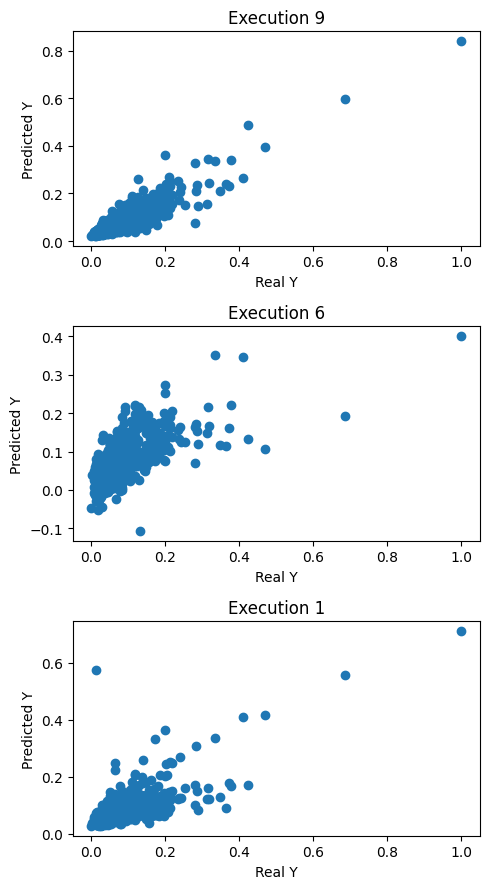

In [31]:
import matplotlib.pyplot as plt
import math

# n = len(neural_net_result_params)
n = 3
fig, axes = plt.subplots(n, 1, figsize=(5, 3*n))
if n == 1:
    axes = [axes]

neural_net_result_params_items = sorted(neural_net_result_params.items(), key=lambda x: x[1]["MAE"])[:n]
for i, (key, value) in enumerate(neural_net_result_params_items):
    Yi_pred = value["Y_pred"]
    Yi_pred = Yi_pred.reshape(-1)

    axes[i].scatter(y_in, Yi_pred)
    axes[i].set_title(f'Execution {value["Combination"]}')
    axes[i].set_xlabel('Real Y')
    axes[i].set_ylabel('Predicted Y')
plt.tight_layout()
plt.show()

And These are the scatter plots of the evolution of the training and validation error as a function
of the number of epochs of the combinations with lowest MAPE:

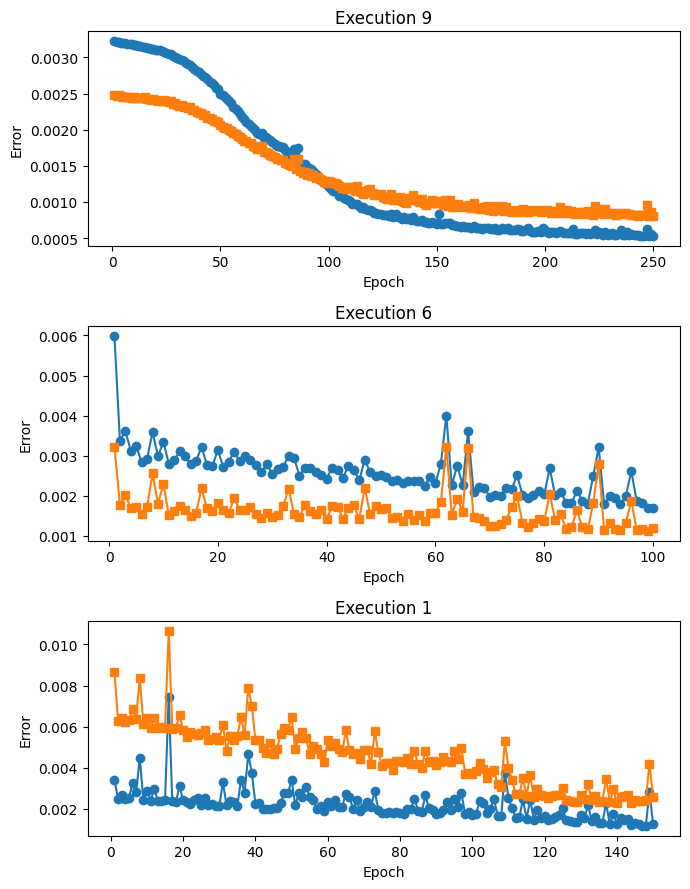

In [41]:
import matplotlib.pyplot as plt
import math

# n = len(neural_net_result_params)
n = 3
fig, axes = plt.subplots(n, 1, figsize=(7, 3*n))
if n == 1:
    axes = [axes]

neural_net_result_params_items = sorted(neural_net_result_params.items(), key=lambda x: x[1]["MAE"])[:n]
for i, (key, value) in enumerate(neural_net_result_params_items):
    training_errors, validation_errors = value["Epoch_loss"]
    epochs = range(1, len(training_errors) + 1)
    
    axes[i].plot(epochs, training_errors, label='Training Error', marker='o')
    axes[i].plot(epochs, validation_errors, label='Validation Error', marker='s')
    axes[i].set_title(f'Execution {value["Combination"]}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Error')
plt.tight_layout()
plt.show()